<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
# %load_ext watermark
# %watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

# Energy reconstruction via ML regression
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Weight simulation events to spectrum](#Weight-simulation-events-to-spectrum)
3. [S125 verification](#S125-verification)
4. [$\log_{10}(\mathrm{dE/dX})$ verification](#$\log_{10}(\mathrm{dE/dX})$-verification)

In [2]:
from __future__ import division, print_function
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import seaborn as sns
import dask
from dask import delayed, multiprocessing
from dask.diagnostics import ProgressBar
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (validation_curve, cross_val_score,
                                     cross_val_predict, GridSearchCV, 
                                     cross_validate, KFold)
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, make_scorer
from mlxtend.preprocessing import standardize

import comptools as comp

color_dict = comp.get_color_dict()

%matplotlib inline

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

## Define analysis parameters and load simulation

In [3]:
# feature_list = ['lap_cos_zenith', 'log_s125']
# feature_list = ['log_s80', 'log_s125', 'log_s250', 'lap_cos_zenith',
#                 'FractionContainment_Laputop_IceTop', 'NStations']

feature_list = ['log_s125', 'lap_cos_zenith', 'log_dEdX']
feature_labels = ['$\mathrm{\log_{10}(S_{125})}$', '$\mathrm{\cos(\\theta)}$', '$\mathrm{\log_{10}(dE/dX)}$']

# feature_list = ['log_s50', 'log_s125', 'log_s180', 'log_s250', 'lap_cos_zenith', 'log_dEdX',
#                 'FractionContainment_Laputop_IceTop']
# feature_labels = ['$\mathrm{\log_{10}(S_{50})}$', '$\mathrm{\log_{10}(S_{125})}$', '$\mathrm{\log_{10}(S_{180})}$', 
#                   '$\mathrm{\log_{10}(S_{250})}$', '$\mathrm{\cos(\\theta)}$', '$\mathrm{\log_{10}(dE/dX)}$',
#                   'IT containment']

# config = 'IC86.2012'
config = 'IC79.2010'
num_groups = 4
comp_list = comp.get_comp_list(num_groups=num_groups)
# feature_list, feature_labels = comp.get_training_features()
pipeline_str = 'RF_energy_{}'.format(config)

In [4]:
energybins = comp.get_energybins(config)
log_energy_min = 5.0
log_energy_max = None

In [5]:
feature_list

['log_s125', 'lap_cos_zenith', 'log_dEdX']

In [6]:
df_sim_train, df_sim_test = comp.load_sim(config=config,
                                          energy_key='MC_log_energy', 
                                          log_energy_min=log_energy_min,
                                          log_energy_max=log_energy_max,
                                          verbose=True)

[########################################] | 100% Completed |  7.7s


/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
for df in [df_sim_train, df_sim_test]:
    df['energy_s125_diff'] = df['MC_log_energy'] - df['log_s125']

In [8]:
df_sim_train.MC_log_energy.min(), df_sim_train.MC_log_energy.max()

(5.1365840857113021, 9.4994529094824749)

Construct composition masking array for testing and training sets

In [9]:
comp_mask_train, comp_mask_test = {}, {}
for composition in comp_list:
    comp_mask_train[composition] = df_sim_train['comp_group_{}'.format(num_groups)] == composition
    comp_mask_test[composition] = df_sim_test['comp_group_{}'.format(num_groups)] == composition

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


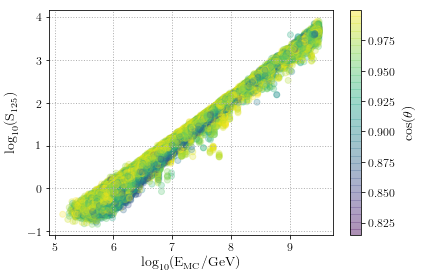

In [8]:
fig, ax = plt.subplots()
sc = ax.scatter(df_sim_train['MC_log_energy'], df_sim_train['log_s125'],
                c=df_sim_train['lap_cos_zenith'], alpha=0.25)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
plt.colorbar(sc, label='$\mathrm{\cos(\\theta)}$')
s125_vs_MC_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         's125_vs_MC_energy_zenith.png')
comp.check_output_dir(s125_vs_MC_energy_outfile)
# plt.savefig(s125_vs_MC_energy_outfile)
plt.show()

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


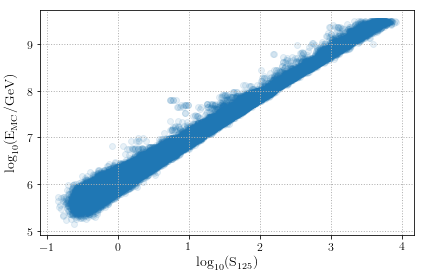

In [13]:
fig, ax = plt.subplots()
sc = ax.scatter(df_sim_train['log_s125'], df_sim_train['MC_log_energy'],
                alpha=0.1)
ax.set_ylabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_xlabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
# plt.colorbar(sc, label='$\mathrm{\cos(\\theta)}$')
# s125_vs_MC_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
#                                          's125_vs_MC_energy_zenith.png')
# comp.check_output_dir(s125_vs_MC_energy_outfile)
# plt.savefig(s125_vs_MC_energy_outfile)
plt.show()

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


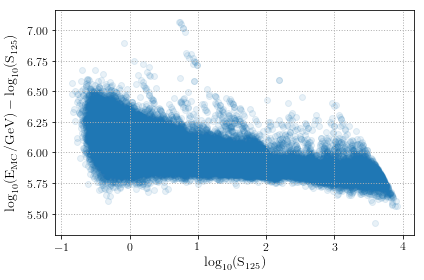

In [12]:
fig, ax = plt.subplots()
sc = ax.scatter(df_sim_train['log_s125'], df_sim_train['energy_s125_diff'],
                alpha=0.1)
ax.set_ylabel('$\mathrm{\log_{10}(E_{MC}/GeV) - \log_{10}(S_{125})}$')
ax.set_xlabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
# plt.colorbar(sc, label='$\mathrm{\cos(\\theta)}$')
# s125_vs_MC_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
#                                          's125_vs_MC_energy_zenith.png')
# comp.check_output_dir(s125_vs_MC_energy_outfile)
# plt.savefig(s125_vs_MC_energy_outfile)
plt.show()

## Explore energy reconstruction training features 

$\mathrm{\log_{10}(S_{125})}$ is highly correlated with true energy, and only has a slight composition dependence. This makes it an important training feature in energy reconstruction. 

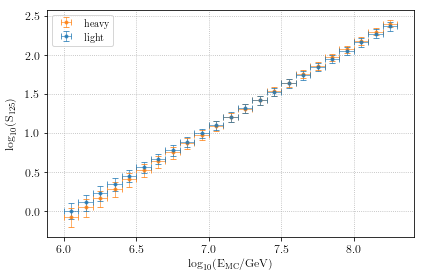

In [52]:
fig, ax = plt.subplots()
for composition in comp_list:
    log_s125 = df_sim_train.loc[comp_mask_train[composition], 'log_s125']
    MC_log_energy = df_sim_train.loc[comp_mask_train[composition], 'MC_log_energy']

    _, bin_medians, error = comp.analysis.get_medians(MC_log_energy, log_s125,
                                                      energybins.log_energy_bins)
    ax.errorbar(energybins.log_energy_midpoints, bin_medians, yerr=error, xerr=0.05, 
                marker='.', ls='None', label=composition, color=color_dict[composition], alpha=0.75)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
ax.legend()
plt.show()

$\mathrm{\log_{10}(dE/dX)}$ too is correlated with true energy, but has the added benefit of being composition dependent as well. This means that an energy reconstruction regressor can also learn composition-dependence of __________.

In [24]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['log_dEdX'],
                                    bins=[np.linspace(6.0, 8.0, 100), np.linspace(-0.5, 3, 100)])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

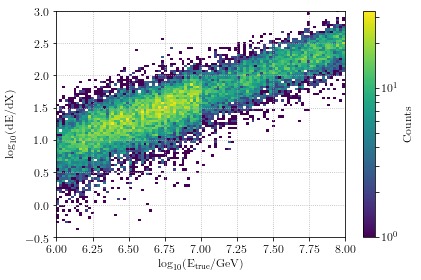

In [25]:
fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(dE/dX)}$')
ax.grid()
plt.colorbar(label='Counts')
# true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
#                                          'MC_vs_reco_energy.png')
# comp.check_output_dir(true_vs_reco_energy_outfile)
# plt.savefig(true_vs_reco_energy_outfile)
plt.show()

## Train a RandomForestRegressor to predict shower energy

Define scoring function

In [ ]:
def median_energy_res(log_energy, log_energy_pred):
    return np.median(log_energy-log_energy_pred)
scorer = make_scorer(median_energy_res, greater_is_better=False)

In [ ]:
# parameters = {'max_depth': np.arange(1, 11), 'n_estimators': np.arange(1, 100, 10)}
# gs = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error',
#                   cv=10, n_jobs=10, verbose=2)

# # parameters = {'C': np.linspace(0.01, 1, 10)}
# # gs = GridSearchCV(SVR(), parameters, cv=10, n_jobs=10, verbose=2)

In [ ]:
# gs.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
# gs.best_params_

In [ ]:
# cv_results = pd.DataFrame(gs.cv_results_)

In [6]:
# # clf = gs.best_estimator_
# pipeline_str = 'RF_energy'
# pipeline = comp.get_pipeline(pipeline_str)
# pipeline

Pipeline(memory=None,
     steps=[('classifier', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
           oob_score=False, random_state=2, verbose=0, warm_start=False))])

In [8]:
# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=2)
# clf = RandomForestRegressor(n_estimators=100, n_jobs=10, random_state=2)

In [9]:
cv_results = cross_validate(pipeline, df_sim_train[feature_list], df_sim_train['MC_log_energy'], 
                            cv=10, verbose=2)

[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


In [20]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
train_score_mean = np.mean(cv_results['train_score'])
train_score_std = np.std(cv_results['train_score'])
print('Training score = {:0.3f} +/- {:0.2e}'.format(train_score_mean, train_score_std))
test_score_mean = np.mean(cv_results['test_score'])
test_score_std = np.std(cv_results['test_score'])
print('Testing score = {:0.3f} +/- {:0.2e}'.format(test_score_mean, test_score_std))
print('=' * 30)

RandomForestRegressor
Training score = 0.990 +/- 1.24e-04
Testing score = 0.987 +/- 3.78e-04


In [16]:
pipeline = comp.get_pipeline(pipeline_str)
pipeline.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
reco_log_energy = pipeline.predict(df_sim_test[feature_list])

In [14]:
pipeline = comp.get_pipeline(pipeline_str)
pipeline.fit(df_sim_train[feature_list], df_sim_train['energy_s125_diff'])
reco_log_energy_2 = pipeline.predict(df_sim_test[feature_list]) + df_sim_test['log_s125'].values

In [13]:
reco_log_energy

array([ 6.39116532,  7.50361264,  5.8203814 , ...,  6.10354272,
        6.8517335 ,  6.73852935])

In [14]:
reco_log_energy.max()

9.4960940122236366

1) 0.8124082064847237
2) 0.11555710227626198
3) 0.07203469123901485


/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


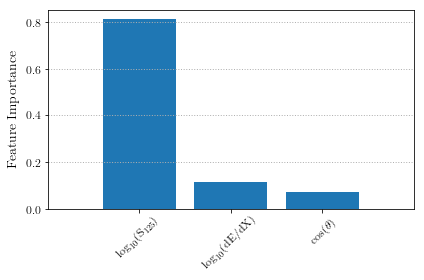

In [15]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

ax.set_ylabel('Feature Importance')
ax.bar(range(num_features), importances[indices], align='center')
plt.xticks(range(num_features), np.array(feature_labels)[indices], rotation=45)
ax.set_xlim([-1, len(feature_list)])
ax.grid(axis='y')
feature_importance_outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation',
                                          'energy-feature-importance-{}.png'.format(config))
comp.check_output_dir(feature_importance_outfile)
plt.savefig(feature_importance_outfile)
plt.show()

## Feature stress tests

In [15]:
n_samples = 100
df_sample = df_sim_train.sample(n_samples, random_state=2)
df_sample = df_sample.sort_values('MC_log_energy')

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


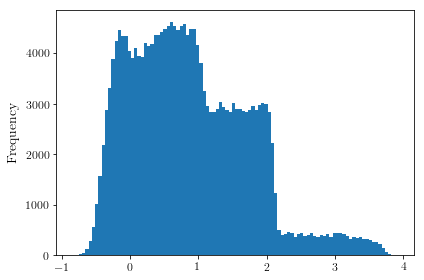

In [16]:
df_sim_train['log_s125'].plot(kind='hist', bins=100)

In [26]:
# log_s125_samples = np.sort(df_sim_train['log_s125'].sample(100))
log_s125_samples = np.linspace(0, 3, 100)
log_s125_index = feature_list.index('log_s125')

stress_test = {}
for name, row in df_sample.iterrows():
    row_X = row[feature_list].values.copy()
    row_X = np.array([row_X for _ in range(len(log_s125_samples))])
    row_X[:, log_s125_index] = log_s125_samples
    pred = pipeline.predict(row_X) + row_X[:, log_s125_index]
    stress_test[name] = pred

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


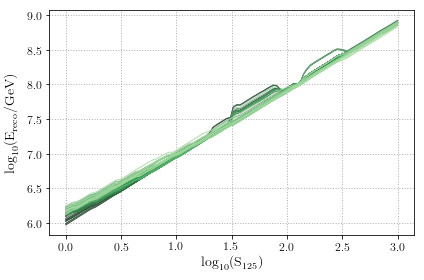

In [27]:
fig, ax = plt.subplots()
colors = sns.color_palette('Greens_d', len(stress_test))
for key, color in zip(stress_test, colors):
    pred = stress_test[key]
    ax.plot(log_s125_samples, pred, marker='None', ls='-', color=color, alpha=0.7)
ax.set_xlabel('$\mathrm{\log_{10}(S_{125})}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
s125_stress_test_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                        's125_stress_test.png')
comp.check_output_dir(s125_stress_test_outfile)
plt.savefig(s125_stress_test_outfile)
plt.show()

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


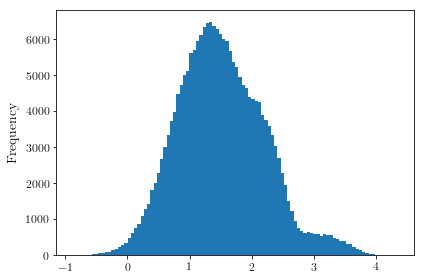

In [28]:
df_sim_train['log_dEdX'].plot(kind='hist', bins=100)

In [29]:
# log_dEdX_samples = np.sort(df_sim_train['log_dEdX'].sample(100))
log_dEdX_samples = np.linspace(0, 3, 100)
log_dEdX_index = feature_list.index('log_dEdX')

stress_test = {}
for name, row in df_sample.iterrows():
    row_X = row[feature_list].values.copy()
    row_X = np.array([row_X for _ in range(len(log_dEdX_samples))])
    row_X[:, log_dEdX_index] = log_dEdX_samples
    pred = pipeline.predict(row_X) + row_X[:, log_s125_index]
    stress_test[name] = pred

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


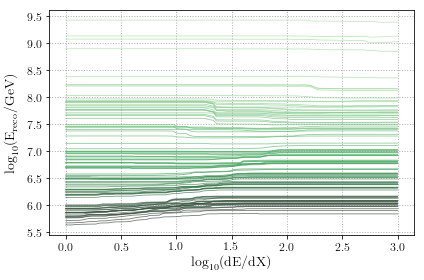

In [30]:
fig, ax = plt.subplots()
colors = sns.color_palette('Greens_d', len(stress_test))
for key, color in zip(stress_test, colors):
    pred = stress_test[key]
    ax.plot(log_dEdX_samples, pred, marker='None', ls='-', color=color, alpha=0.7)
ax.set_xlabel('$\mathrm{\log_{10}(dE/dX)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
dEdX_stress_test_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                        'dEdX_stress_test.png')
comp.check_output_dir(dEdX_stress_test_outfile)
plt.savefig(dEdX_stress_test_outfile)
plt.show()

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


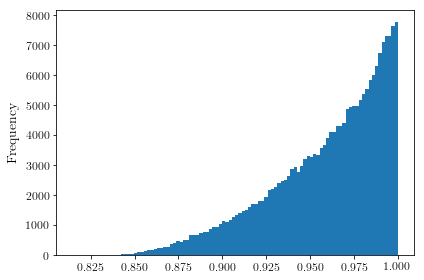

In [31]:
df_sim_train['lap_cos_zenith'].plot(kind='hist', bins=100)

In [32]:
# zenith_samples = np.sort(df_sim_train['lap_cos_zenith'].sample(100))
zenith_samples = np.linspace(0.85, 1, 100)
zenith_index = feature_list.index('lap_cos_zenith')

stress_test = {}
for name, row in df_sample.iterrows():
    row_X = row[feature_list].values.copy()
    row_X = np.array([row_X for _ in range(len(log_dEdX_samples))])
    row_X[:, zenith_index] = zenith_samples
    pred = pipeline.predict(row_X) + row_X[:, log_s125_index]
    stress_test[name] = pred

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


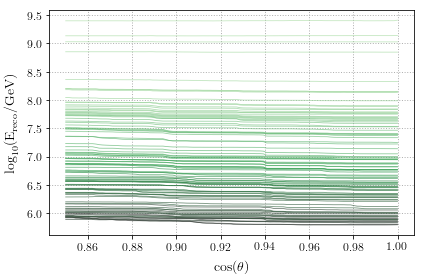

In [33]:
fig, ax = plt.subplots()
colors = sns.color_palette('Greens_d', len(stress_test))
for key, color in zip(stress_test, colors):
    pred = stress_test[key]
    ax.plot(zenith_samples, pred, marker='None', ls='-', color=color, alpha=0.7)
ax.set_xlabel('$\mathrm{\\cos(\\theta)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
zenith_stress_test_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                        'zenith_stress_test.png')
comp.check_output_dir(zenith_stress_test_outfile)
plt.savefig(zenith_stress_test_outfile)
plt.show()

## Model validation

In [48]:
parameters = {'classifier__max_depth': np.arange(1, 16, dtype=int), 
              'classifier__n_estimators': np.arange(10, 320, 20, dtype=int)}

# parameters = {'classifier__max_depth': range(1, 8), 
#               'classifier__n_estimators':[5, 10, 20, 50, 100, 200, 300, 400, 500, 600]}

grid_search = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error',
                           cv=10, n_jobs=20, verbose=2)
grid_search.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy']);

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.7s


[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=30, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=30, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=30, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1,

[CV]  classifier__n_estimators=110, classifier__max_depth=1, total=   1.0s
[CV] classifier__n_estimators=130, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=130, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=110, classifier__max_depth=1, total=   1.1s
[CV] classifier__n_estimators=130, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=130, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=130, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=1, total=   1.3s
[CV]  classifier__n_estimators=130, classifier__max_depth=1, total=   1.5s
[CV] classifier__n_estimators=130, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=1, total=   1.2s
[CV] classifier__n_estimators=150, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=150, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth

[CV] classifier__n_estimators=250, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=250, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=230, classifier__max_depth=1, total=   2.3s
[CV]  classifier__n_estimators=230, classifier__max_depth=1, total=   2.2s
[CV] classifier__n_estimators=250, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=230, classifier__max_depth=1, total=   2.3s
[CV] classifier__n_estimators=250, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=230, classifier__max_depth=1, total=   2.2s
[CV] classifier__n_estimators=250, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=250, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=230, classifier__max_depth=1, total=   2.1s
[CV]  classifier__n_estimators=230, classifier__max_depth=1, total=   1.9s
[CV] classifier__n_estimators=250, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=250, classifier__max_de

[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:   27.6s


[CV]  classifier__n_estimators=250, classifier__max_depth=1, total=   2.4s
[CV]  classifier__n_estimators=250, classifier__max_depth=1, total=   2.4s
[CV] classifier__n_estimators=270, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=1, total=   2.6s
[CV]  classifier__n_estimators=250, classifier__max_depth=1, total=   2.4s
[CV] classifier__n_estimators=270, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=1, total=   2.3s
[CV]  classifier__n_estimators=250, classifier__max_depth=1, total=   2.4s
[CV] classifier__n_estimators=270, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=270, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=270, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=1, total=   2.5s
[CV] classifier__n_estimators=270, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=270, classifier__ma

[CV]  classifier__n_estimators=50, classifier__max_depth=2, total=   0.5s
[CV] classifier__n_estimators=50, classifier__max_depth=2 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=2, total=   0.6s
[CV] classifier__n_estimators=50, classifier__max_depth=2 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=2, total=   0.6s
[CV] classifier__n_estimators=50, classifier__max_depth=2 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=2, total=   0.6s
[CV]  classifier__n_estimators=50, classifier__max_depth=2, total=   0.7s
[CV]  classifier__n_estimators=50, classifier__max_depth=2, total=   0.6s
[CV] classifier__n_estimators=50, classifier__max_depth=2 ............
[CV] classifier__n_estimators=70, classifier__max_depth=2 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=2, total=   0.6s
[CV] classifier__n_estimators=70, classifier__max_depth=2 ............
[CV] classifier__n_estimators=70, classifier__max_depth=

[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=2, total=   2.0s
[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=2, total=   2.0s
[CV]  classifier__n_estimators=150, classifier__max_depth=2, total=   1.6s
[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=2, total=   2.2s
[CV] classifier__n_estimators=170, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=2, total=   2.4s
[CV] classifier__n_estimators=190, classifier__max_depth=

[CV]  classifier__n_estimators=270, classifier__max_depth=2, total=   4.4s
[CV] classifier__n_estimators=290, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=2, total=   4.0s
[CV] classifier__n_estimators=290, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=2, total=   4.3s
[CV]  classifier__n_estimators=270, classifier__max_depth=2, total=   4.9s
[CV] classifier__n_estimators=290, classifier__max_depth=2 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=2, total=   4.1s
[CV] classifier__n_estimators=290, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=2, total=   4.6s
[CV]  classifier__n_estimators=270, classifier__max_depth=2, total=   4.9s
[CV] classifier__n_estimators=290, classifier__max_depth=2 ...........
[CV] classifier__n_estimators=290, classifier__ma

[Parallel(n_jobs=20)]: Done 325 tasks      | elapsed:  1.6min


[CV] classifier__n_estimators=30, classifier__max_depth=3 ............
[CV]  classifier__n_estimators=310, classifier__max_depth=2, total=   9.7s
[CV]  classifier__n_estimators=30, classifier__max_depth=3, total=   1.6s
[CV]  classifier__n_estimators=30, classifier__max_depth=3, total=   1.3s
[CV] classifier__n_estimators=30, classifier__max_depth=3 ............
[CV] classifier__n_estimators=30, classifier__max_depth=3 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=3, total=   0.8s
[CV] classifier__n_estimators=30, classifier__max_depth=3 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=3, total=   0.8s
[CV] classifier__n_estimators=50, classifier__max_depth=3 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=3, total=   1.5s
[CV]  classifier__n_estimators=30, classifier__max_depth=3, total=   0.6s
[CV]  classifier__n_estimators=310, classifier__max_depth=2, total=   9.7s
[CV] classifier__n_estimators=50, classifier__max_d

[CV]  classifier__n_estimators=130, classifier__max_depth=3, total=   3.3s
[CV]  classifier__n_estimators=130, classifier__max_depth=3, total=   2.0s
[CV] classifier__n_estimators=150, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=150, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=3, total=   3.7s
[CV]  classifier__n_estimators=130, classifier__max_depth=3, total=   2.2s
[CV] classifier__n_estimators=150, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=3, total=   2.3s
[CV] classifier__n_estimators=150, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=150, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=3, total=   3.8s
[CV] classifier__n_estimators=150, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=150, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=170, classifier__max_de

[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=230, classifier__max_depth=3, total=   5.6s
[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=3, total=   4.3s
[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=3, total=   4.3s
[CV]  classifier__n_estimators=250, classifier__max_depth=3, total=   4.7s
[CV] classifier__n_estimators=270, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=3, total=   5.9s
[CV]  classifier__n_estimators=250, classifier__max_depth

[CV]  classifier__n_estimators=290, classifier__max_depth=3, total=  21.5s
[CV]  classifier__n_estimators=30, classifier__max_depth=4, total=   1.0s
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=310, classifier__max_depth=3, total=  16.7s
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=4, total=   1.4s
[CV]  classifier__n_estimators=50, classifier__max_depth=4, total=   1.4s
[CV]  classifier__n_estimators=310, classifier__max_depth=3, total=  17.8s
[CV]  classifier__n_estimators=50, classifier__max_depth=4, total=   1.1s
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV] classifier__n_estimators=70, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=50, classifier__max_de

[CV] classifier__n_estimators=170, classifier__max_depth=4 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=4, total=   4.4s
[CV] classifier__n_estimators=170, classifier__max_depth=4 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=4, total=   5.6s
[CV] classifier__n_estimators=170, classifier__max_depth=4 ...........
[CV] classifier__n_estimators=170, classifier__max_depth=4 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=4, total=   5.4s
[CV]  classifier__n_estimators=170, classifier__max_depth=4, total=   4.4s
[CV]  classifier__n_estimators=170, classifier__max_depth=4, total=   4.4s
[CV]  classifier__n_estimators=150, classifier__max_depth=4, total=   7.6s
[CV]  classifier__n_estimators=170, classifier__max_depth=4, total=   3.8s
[CV] classifier__n_estimators=170, classifier__max_depth=4 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=4, total=   7.8s
[CV]  classifier__n_estimators=170, classifie

[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=4, total=   9.8s
[CV]  classifier__n_estimators=250, classifier__max_depth=4, total=   9.8s
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........


[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:  3.9min


[CV]  classifier__n_estimators=270, classifier__max_depth=4, total=   8.6s
[CV]  classifier__n_estimators=250, classifier__max_depth=4, total=   9.4s
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=4, total=  13.4s
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=4 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=4 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=4, total=   8.9s
[CV]  classifier__n_estimators=270, classifier__max_depth=4, total=   6.1s
[CV] classifier__n_estimators=310, classifier__max_depth=

[CV] classifier__n_estimators=70, classifier__max_depth=5 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=5, total=   1.2s
[CV] classifier__n_estimators=70, classifier__max_depth=5 ............
[CV] classifier__n_estimators=70, classifier__max_depth=5 ............
[CV] classifier__n_estimators=70, classifier__max_depth=5 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=5, total=   1.7s
[CV] classifier__n_estimators=70, classifier__max_depth=5 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=5, total=   1.7s
[CV] classifier__n_estimators=90, classifier__max_depth=5 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=5, total=   1.6s
[CV]  classifier__n_estimators=70, classifier__max_depth=5, total=   1.9s
[CV] classifier__n_estimators=90, classifier__max_depth=5 ............
[CV] classifier__n_estimators=90, classifier__max_depth=5 ............
[CV] classifier__n_estimators=90, classifier__max_depth=5 ....

[CV] classifier__n_estimators=190, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=5, total=   8.4s
[CV] classifier__n_estimators=190, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=5, total=   5.7s
[CV]  classifier__n_estimators=150, classifier__max_depth=5, total=  11.5s
[CV]  classifier__n_estimators=170, classifier__max_depth=5, total=   9.6s
[CV] classifier__n_estimators=210, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=210, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=210, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=5, total=  13.1s
[CV] classifier__n_estimators=210, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=5, total=  14.3s
[CV] classifier__n_estimators=210, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=150, classifier__max_d

[CV] classifier__n_estimators=290, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=290, classifier__max_depth=5, total=  18.9s
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=5, total=  20.4s
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=290, classifier__max_depth=5, total=   8.4s
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=5 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=5 ......

[CV] classifier__n_estimators=110, classifier__max_depth=6 ...........
[CV] classifier__n_estimators=110, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=310, classifier__max_depth=5, total=  27.1s
[CV]  classifier__n_estimators=90, classifier__max_depth=6, total=   3.2s
[CV]  classifier__n_estimators=70, classifier__max_depth=6, total=   5.8s
[CV]  classifier__n_estimators=50, classifier__max_depth=6, total=   9.1s
[CV] classifier__n_estimators=110, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=70, classifier__max_depth=6, total=   7.2s
[CV]  classifier__n_estimators=70, classifier__max_depth=6, total=   7.4s
[CV] classifier__n_estimators=110, classifier__max_depth=6 ...........
[CV] classifier__n_estimators=110, classifier__max_depth=6 ...........
[CV] classifier__n_estimators=110, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=90, classifier__max_depth=6, total=   3.9s
[CV]  classifier__n_estimators=70, classifier__max_dept

[CV] classifier__n_estimators=210, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=6, total=   7.4s
[CV] classifier__n_estimators=210, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=6, total=   6.9s
[CV] classifier__n_estimators=210, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=6, total=  21.3s
[CV]  classifier__n_estimators=210, classifier__max_depth=6, total=   8.6s
[CV] classifier__n_estimators=230, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=6, total=  14.5s
[CV]  classifier__n_estimators=190, classifier__max_depth=6, total=  14.5s
[CV]  classifier__n_estimators=190, classifier__max_depth=6, total=  14.2s
[CV]  classifier__n_estimators=190, classifier__max_depth=6, total=  13.8s
[CV]  classifier__n_estimators=170, classifier__max_depth=6, total=  26.5s
[CV]  classifier__n_estimators=210, class

[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV]  classifier__n_estimators=310, classifier__max_depth=6, total=  17.6s
[CV]  classifier__n_estimators=310, classifier__max_depth=6, total=  22.2s
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV]  classifier__n_estimators=290, classifier__max_depth=6, total=  32.2s
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=10, classifier__max_depth=7 ............
[CV] classifier__n_estimators=30, classifier__max_depth=7 .......

[Parallel(n_jobs=20)]: Done 973 tasks      | elapsed:  8.3min


[CV] classifier__n_estimators=50, classifier__max_depth=7 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=7, total=   1.0s
[CV] classifier__n_estimators=70, classifier__max_depth=7 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=7, total=   4.7s
[CV]  classifier__n_estimators=50, classifier__max_depth=7, total=   1.9s
[CV] classifier__n_estimators=70, classifier__max_depth=7 ............
[CV] classifier__n_estimators=70, classifier__max_depth=7 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=7, total=   4.5s
[CV]  classifier__n_estimators=50, classifier__max_depth=7, total=   2.7s
[CV]  classifier__n_estimators=50, classifier__max_depth=7, total=   2.7s
[CV]  classifier__n_estimators=50, classifier__max_depth=7, total=   2.1s
[CV]  classifier__n_estimators=50, classifier__max_depth=7, total=   3.3s
[CV]  classifier__n_estimators=50, classifier__max_depth=7, total=   3.1s
[CV]  classifier__n_estimators=50, classifier__max

[CV]  classifier__n_estimators=130, classifier__max_depth=7, total=  17.4s
[CV] classifier__n_estimators=170, classifier__max_depth=7 ...........
[CV] classifier__n_estimators=170, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=7, total=   5.3s
[CV]  classifier__n_estimators=150, classifier__max_depth=7, total=  14.6s
[CV] classifier__n_estimators=170, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=7, total=   4.4s
[CV] classifier__n_estimators=190, classifier__max_depth=7 ...........
[CV] classifier__n_estimators=190, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=110, classifier__max_depth=7, total=  23.4s
[CV] classifier__n_estimators=190, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=7, total=  21.3s
[CV]  classifier__n_estimators=150, classifier__max_depth=7, total=  14.5s
[CV] classifier__n_estimators=190, classifier__ma

[CV] classifier__n_estimators=270, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=7, total=  13.2s
[CV]  classifier__n_estimators=250, classifier__max_depth=7, total=  26.1s
[CV] classifier__n_estimators=270, classifier__max_depth=7 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=7, total=  14.7s
[CV] classifier__n_estimators=290, classifier__max_depth=7 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=7 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=7, total=  26.2s
[CV]  classifier__n_estimators=270, classifier__max_depth=7, total=  22.6s
[CV]  classifier__n_estimators=270, classifier__max_depth=7, total=  19.9s
[CV]  classifier__n_estimators=230, classifier__max_depth=7, total=  46.8s
[CV]  classifier__n_estimators=290, classifier__m

[CV] classifier__n_estimators=70, classifier__max_depth=8 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=8, total=   3.5s
[CV]  classifier__n_estimators=50, classifier__max_depth=8, total=   5.5s
[CV] classifier__n_estimators=90, classifier__max_depth=8 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=8, total=   4.3s
[CV] classifier__n_estimators=90, classifier__max_depth=8 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=8, total=   4.2s
[CV] classifier__n_estimators=90, classifier__max_depth=8 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=8, total=   2.7s
[CV] classifier__n_estimators=90, classifier__max_depth=8 ............
[CV] classifier__n_estimators=90, classifier__max_depth=8 ............
[CV] classifier__n_estimators=90, classifier__max_depth=8 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=8, total=  16.8s
[CV] classifier__n_estimators=90, classifier__max_depth=8 .

[CV]  classifier__n_estimators=170, classifier__max_depth=8, total=  16.5s
[CV] classifier__n_estimators=190, classifier__max_depth=8 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=8, total=  19.7s
[CV]  classifier__n_estimators=170, classifier__max_depth=8, total=  14.5s
[CV]  classifier__n_estimators=170, classifier__max_depth=8, total=  16.9s
[CV]  classifier__n_estimators=150, classifier__max_depth=8, total=  23.0s
[CV]  classifier__n_estimators=150, classifier__max_depth=8, total=  22.8s
[CV] classifier__n_estimators=190, classifier__max_depth=8 ...........
[CV] classifier__n_estimators=190, classifier__max_depth=8 ...........
[CV] classifier__n_estimators=190, classifier__max_depth=8 ...........
[CV] classifier__n_estimators=190, classifier__max_depth=8 ...........
[CV] classifier__n_estimators=190, classifier__max_depth=8 ...........
[CV] classifier__n_estimators=190, classifier__max_depth=8 ...........
[CV]  classifier__n_estimators=190, classifier__max_d

[CV]  classifier__n_estimators=250, classifier__max_depth=8, total=  46.4s
[CV]  classifier__n_estimators=250, classifier__max_depth=8, total=  46.4s
[CV]  classifier__n_estimators=270, classifier__max_depth=8, total=  45.5s
[CV]  classifier__n_estimators=290, classifier__max_depth=8, total=  21.0s
[CV] classifier__n_estimators=310, classifier__max_depth=8 ...........
[CV]  classifier__n_estimators=310, classifier__max_depth=8, total=  12.4s
[CV]  classifier__n_estimators=290, classifier__max_depth=8, total=  13.6s
[CV]  classifier__n_estimators=230, classifier__max_depth=8, total= 1.0min
[CV]  classifier__n_estimators=310, classifier__max_depth=8, total=  14.4s
[CV]  classifier__n_estimators=290, classifier__max_depth=8, total=  19.5s
[CV]  classifier__n_estimators=290, classifier__max_depth=8, total=  29.2s
[CV]  classifier__n_estimators=270, classifier__max_depth=8, total=  51.2s
[CV]  classifier__n_estimators=290, classifier__max_depth=8, total=  28.3s
[CV]  classifier__n_estimator

[CV]  classifier__n_estimators=70, classifier__max_depth=9, total=   7.1s
[CV]  classifier__n_estimators=70, classifier__max_depth=9, total=   6.8s
[CV]  classifier__n_estimators=70, classifier__max_depth=9, total=   7.3s
[CV]  classifier__n_estimators=70, classifier__max_depth=9, total=   7.7s
[CV] classifier__n_estimators=90, classifier__max_depth=9 ............
[CV]  classifier__n_estimators=90, classifier__max_depth=9, total=   8.2s
[CV]  classifier__n_estimators=70, classifier__max_depth=9, total=  10.4s
[CV]  classifier__n_estimators=90, classifier__max_depth=9, total=   4.4s
[CV] classifier__n_estimators=90, classifier__max_depth=9 ............
[CV] classifier__n_estimators=90, classifier__max_depth=9 ............
[CV] classifier__n_estimators=90, classifier__max_depth=9 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=9, total=  12.5s
[CV]  classifier__n_estimators=50, classifier__max_depth=9, total=  15.1s
[CV] classifier__n_estimators=90, classifier__max_

[CV]  classifier__n_estimators=190, classifier__max_depth=9, total=   7.1s
[CV] classifier__n_estimators=210, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=210, classifier__max_depth=9, total=   8.5s
[CV] classifier__n_estimators=210, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=9, total=  21.0s
[CV] classifier__n_estimators=210, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=210, classifier__max_depth=9, total=   4.7s
[CV] classifier__n_estimators=210, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=9, total=  34.3s
[CV] classifier__n_estimators=230, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=9, total=  28.8s
[CV] classifier__n_estimators=230, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=210, classifier__max_depth=9, total=   5.2s
[CV] classifier__n_estimators=230, classifier__ma

[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed: 16.0min


[CV] classifier__n_estimators=310, classifier__max_depth=9 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=290, classifier__max_depth=9, total=  30.6s
[CV]  classifier__n_estimators=290, classifier__max_depth=9, total=  19.6s
[CV] classifier__n_estimators=10, classifier__max_depth=10 ...........
[CV]  classifier__n_estimators=10, classifier__max_depth=10, total=   1.7s
[CV]  classifier__n_estimators=290, classifier__max_depth=9, total=  33.4s
[CV]  classifier__n_estimators=290, classifier__max_depth=9, total=  32.3s
[CV] classifier__n_estimators=10, classifier__max_depth=10 ...........
[CV]  classifier__n_estimators=290, classifier__max_depth=9, total=  17.4s
[CV]  classifier__n_estimators=310, classifier__max_depth=9, total=  12.2s
[CV]  classifier__n_estimators=270, classifier__max_depth=9, total=  36.6s
[CV]  classifier__n_estimators=10, classifier__max_depth=10, total=   2.5s
[CV]  classifier__n_estimators=290, class

[CV] classifier__n_estimators=110, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=70, classifier__max_depth=10, total=   4.7s
[CV] classifier__n_estimators=110, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=10, total=   2.6s
[CV] classifier__n_estimators=110, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=70, classifier__max_depth=10, total=  11.4s
[CV] classifier__n_estimators=130, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=10, total=   7.7s
[CV] classifier__n_estimators=130, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=10, 

[CV] classifier__n_estimators=230, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=  18.7s
[CV] classifier__n_estimators=230, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=  19.6s
[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=  15.5s
[CV] classifier__n_estimators=230, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=210, classifier__max_depth=10, total=  10.2s
[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=  19.9s
[CV] classifier__n_estimators=230, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=  11.6s
[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=  12.1s
[CV] classifier__n_estimators=230, classif

[CV] classifier__n_estimators=10, classifier__max_depth=11 ...........
[CV]  classifier__n_estimators=290, classifier__max_depth=10, total=  39.6s
[CV]  classifier__n_estimators=10, classifier__max_depth=11, total=   2.2s
[CV] classifier__n_estimators=10, classifier__max_depth=11 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=10, total=  54.1s
[CV] classifier__n_estimators=10, classifier__max_depth=11 ...........
[CV]  classifier__n_estimators=10, classifier__max_depth=11, total=   2.2s
[CV]  classifier__n_estimators=10, classifier__max_depth=11, total=   2.8s
[CV]  classifier__n_estimators=10, classifier__max_depth=11, total=   2.5s
[CV]  classifier__n_estimators=310, classifier__max_depth=10, total=  13.6s
[CV]  classifier__n_estimators=10, classifier__max_depth=11, total=   4.6s
[CV]  classifier__n_estimators=270, classifier__max_depth=10, total=  58.0s
[CV] classifier__n_estimators=10, classifier__max_depth=11 ...........
[CV]  classifier__n_estimators=10, cl

[CV]  classifier__n_estimators=90, classifier__max_depth=11, total=  12.8s
[CV]  classifier__n_estimators=110, classifier__max_depth=11, total=   4.1s
[CV] classifier__n_estimators=130, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=11, total=  11.3s
[CV] classifier__n_estimators=130, classifier__max_depth=11 ..........
[CV] classifier__n_estimators=130, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=70, classifier__max_depth=11, total=  14.4s
[CV] classifier__n_estimators=130, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=11, total=   9.9s
[CV] classifier__n_estimators=130, classifier__max_depth=11 ..........
[CV] classifier__n_estimators=130, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=110, classifier__max_depth=11, total=   6.6s
[CV] classifier__n_estimators=130, classifier__max_depth=11 ..........
[CV] classifier__n_estimators=130, classifier__max_

[CV]  classifier__n_estimators=210, classifier__max_depth=11, total=  16.1s
[CV]  classifier__n_estimators=210, classifier__max_depth=11, total=  14.8s
[CV]  classifier__n_estimators=210, classifier__max_depth=11, total=  18.0s
[CV] classifier__n_estimators=230, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=11, total=  37.5s
[CV]  classifier__n_estimators=230, classifier__max_depth=11, total=  16.4s
[CV] classifier__n_estimators=230, classifier__max_depth=11 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=11 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=210, classifier__max_depth=11, total=  19.3s
[CV] classifier__n_estimators=230, classifier__max_depth=11 ..........
[CV] classifier__n_estimators=250, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=11, total=  41.0s
[CV] classifier__n_estimators=250, classif

[CV] classifier__n_estimators=30, classifier__max_depth=12 ...........
[CV]  classifier__n_estimators=290, classifier__max_depth=11, total=  40.7s
[CV]  classifier__n_estimators=30, classifier__max_depth=12, total=   2.4s
[CV] classifier__n_estimators=30, classifier__max_depth=12 ...........
[CV] classifier__n_estimators=30, classifier__max_depth=12 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=11, total= 1.1min
[CV]  classifier__n_estimators=30, classifier__max_depth=12, total=   2.6s
[CV] classifier__n_estimators=30, classifier__max_depth=12 ...........
[CV] classifier__n_estimators=30, classifier__max_depth=12 ...........
[CV]  classifier__n_estimators=30, classifier__max_depth=12, total=   2.8s
[CV] classifier__n_estimators=50, classifier__max_depth=12 ...........
[CV]  classifier__n_estimators=30, classifier__max_depth=12, total=   3.9s
[CV]  classifier__n_estimators=30, classifier__max_depth=12, total=   2.1s
[CV] classifier__n_estimators=50, classifier__m

[CV] classifier__n_estimators=150, classifier__max_depth=12 ..........
[CV]  classifier__n_estimators=130, classifier__max_depth=12, total=   7.9s
[CV]  classifier__n_estimators=110, classifier__max_depth=12, total=  18.4s
[CV]  classifier__n_estimators=130, classifier__max_depth=12, total=  13.5s
[CV] classifier__n_estimators=150, classifier__max_depth=12 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=12, total=  20.3s
[CV]  classifier__n_estimators=130, classifier__max_depth=12, total=  11.5s
[CV]  classifier__n_estimators=110, classifier__max_depth=12, total=  16.4s
[CV]  classifier__n_estimators=90, classifier__max_depth=12, total=  20.8s
[CV]  classifier__n_estimators=130, classifier__max_depth=12, total=  12.2s
[CV]  classifier__n_estimators=130, classifier__max_depth=12, total=  14.2s
[CV] classifier__n_estimators=150, classifier__max_depth=12 ..........
[CV]  classifier__n_estimators=130, classifier__max_depth=12, total=  14.6s
[CV] classifier__n_estimators

[CV]  classifier__n_estimators=210, classifier__max_depth=12, total=  28.3s
[CV]  classifier__n_estimators=190, classifier__max_depth=12, total=  54.2s
[CV]  classifier__n_estimators=250, classifier__max_depth=12, total=  19.4s
[CV] classifier__n_estimators=250, classifier__max_depth=12 ..........
[CV]  classifier__n_estimators=210, classifier__max_depth=12, total=  34.0s
[CV] classifier__n_estimators=250, classifier__max_depth=12 ..........
[CV]  classifier__n_estimators=230, classifier__max_depth=12, total=  21.5s
[CV]  classifier__n_estimators=230, classifier__max_depth=12, total=  24.3s
[CV]  classifier__n_estimators=230, classifier__max_depth=12, total=  35.7s
[CV] classifier__n_estimators=250, classifier__max_depth=12 ..........
[CV]  classifier__n_estimators=250, classifier__max_depth=12, total=  25.3s
[CV] classifier__n_estimators=250, classifier__max_depth=12 ..........
[CV]  classifier__n_estimators=230, classifier__max_depth=12, total=  34.3s
[CV]  classifier__n_estimators=2

[CV]  classifier__n_estimators=30, classifier__max_depth=13, total=   3.7s
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=30, classifier__max_depth=13, total=   6.9s
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=30, classifier__max_depth=13, total=   4.6s
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=30, classifier__max_depth=13, total=   6.0s
[CV] classifier__n_estimators=50, classifier__max_depth=13 ..

[Parallel(n_jobs=20)]: Done 1945 tasks      | elapsed: 25.8min


[CV] classifier__n_estimators=70, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=50, classifier__max_depth=13, total=  13.1s
[CV]  classifier__n_estimators=50, classifier__max_depth=13, total=  12.2s
[CV]  classifier__n_estimators=50, classifier__max_depth=13, total=  12.6s
[CV]  classifier__n_estimators=50, classifier__max_depth=13, total=  11.6s
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=90, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=70, classifier__max_depth=13, 

[CV]  classifier__n_estimators=150, classifier__max_depth=13, total=  30.8s
[CV]  classifier__n_estimators=190, classifier__max_depth=13, total=  14.4s
[CV] classifier__n_estimators=210, classifier__max_depth=13 ..........
[CV]  classifier__n_estimators=170, classifier__max_depth=13, total=  22.1s
[CV]  classifier__n_estimators=170, classifier__max_depth=13, total=  21.1s
[CV] classifier__n_estimators=210, classifier__max_depth=13 ..........
[CV]  classifier__n_estimators=170, classifier__max_depth=13, total=  25.3s
[CV] classifier__n_estimators=210, classifier__max_depth=13 ..........
[CV]  classifier__n_estimators=170, classifier__max_depth=13, total=  16.2s
[CV] classifier__n_estimators=210, classifier__max_depth=13 ..........
[CV] classifier__n_estimators=210, classifier__max_depth=13 ..........
[CV] classifier__n_estimators=210, classifier__max_depth=13 ..........
[CV]  classifier__n_estimators=170, classifier__max_depth=13, total=  25.0s
[CV] classifier__n_estimators=210, classif

[CV] classifier__n_estimators=310, classifier__max_depth=13 ..........
[CV]  classifier__n_estimators=290, classifier__max_depth=13, total=  33.0s
[CV]  classifier__n_estimators=270, classifier__max_depth=13, total=  48.8s
[CV]  classifier__n_estimators=290, classifier__max_depth=13, total=  33.5s
[CV]  classifier__n_estimators=290, classifier__max_depth=13, total=  32.1s
[CV] classifier__n_estimators=310, classifier__max_depth=13 ..........
[CV]  classifier__n_estimators=270, classifier__max_depth=13, total=  43.1s
[CV] classifier__n_estimators=310, classifier__max_depth=13 ..........
[CV] classifier__n_estimators=310, classifier__max_depth=13 ..........
[CV] classifier__n_estimators=310, classifier__max_depth=13 ..........
[CV] classifier__n_estimators=10, classifier__max_depth=14 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=13, total=  58.8s
[CV] classifier__n_estimators=10, classifier__max_depth=14 ...........
[CV] classifier__n_estimators=10, classifier__m

[CV]  classifier__n_estimators=70, classifier__max_depth=14, total=  23.1s
[CV] classifier__n_estimators=90, classifier__max_depth=14 ...........
[CV]  classifier__n_estimators=70, classifier__max_depth=14, total=  25.3s
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=70, classifier__max_depth=14, total=  25.2s
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=14, total=  15.3s
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=14, 

[CV] classifier__n_estimators=210, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=210, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=210, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=210, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=210, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=14, total=  14.4s
[CV] classifier__n_estimators=230, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=14, total=  16.4s
[CV] classifier__n_estimators=230, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=190, classifier__max_depth=14, total=  20.0s
[CV] classifier__n_estimators=230, classifier__max_depth=14 ..

[CV]  classifier__n_estimators=10, classifier__max_depth=15, total=   6.6s
[CV] classifier__n_estimators=10, classifier__max_depth=15 ...........
[CV]  classifier__n_estimators=10, classifier__max_depth=15, total=   3.4s
[CV]  classifier__n_estimators=290, classifier__max_depth=14, total=  49.5s
[CV] classifier__n_estimators=10, classifier__max_depth=15 ...........
[CV] classifier__n_estimators=10, classifier__max_depth=15 ...........
[CV] classifier__n_estimators=10, classifier__max_depth=15 ...........
[CV] classifier__n_estimators=10, classifier__max_depth=15 ...........
[CV]  classifier__n_estimators=10, classifier__max_depth=15, total=   3.5s
[CV]  classifier__n_estimators=10, classifier__max_depth=15, total=   4.0s
[CV] classifier__n_estimators=10, classifier__max_depth=15 ...........
[CV]  classifier__n_estimators=310, classifier__max_depth=14, total=  33.2s
[CV]  classifier__n_estimators=290, classifier__max_depth=14, total=  52.9s
[CV]  classifier__n_estimators=10, classifier_

[CV]  classifier__n_estimators=90, classifier__max_depth=15, total=   9.3s
[CV]  classifier__n_estimators=70, classifier__max_depth=15, total=  16.2s
[CV]  classifier__n_estimators=90, classifier__max_depth=15, total=   8.7s
[CV] classifier__n_estimators=130, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=15, total=   8.8s
[CV]  classifier__n_estimators=110, classifier__max_depth=15, total=   9.0s
[CV] classifier__n_estimators=130, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=110, classifier__max_depth=15, total=   9.2s
[CV] classifier__n_estimators=130, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=130, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=130, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=15, total=  19.9s
[CV] classifier__n_estimators=130, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=110, classifier_

[CV]  classifier__n_estimators=210, classifier__max_depth=15, total=  27.2s
[CV]  classifier__n_estimators=230, classifier__max_depth=15, total=  23.7s
[CV]  classifier__n_estimators=190, classifier__max_depth=15, total=  52.8s
[CV]  classifier__n_estimators=210, classifier__max_depth=15, total=  27.4s
[CV]  classifier__n_estimators=230, classifier__max_depth=15, total=  21.4s
[CV] classifier__n_estimators=230, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=210, classifier__max_depth=15, total=  30.2s
[CV] classifier__n_estimators=230, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=230, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=250, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=210, classifier_

[Parallel(n_jobs=20)]: Done 2400 out of 2400 | elapsed: 37.6min finished


In [49]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.columns

Index([u'mean_fit_time', u'mean_score_time', u'mean_test_score',
       u'mean_train_score', u'param_classifier__max_depth',
       u'param_classifier__n_estimators', u'params', u'rank_test_score',
       u'split0_test_score', u'split0_train_score', u'split1_test_score',
       u'split1_train_score', u'split2_test_score', u'split2_train_score',
       u'split3_test_score', u'split3_train_score', u'split4_test_score',
       u'split4_train_score', u'split5_test_score', u'split5_train_score',
       u'split6_test_score', u'split6_train_score', u'split7_test_score',
       u'split7_train_score', u'split8_test_score', u'split8_train_score',
       u'split9_test_score', u'split9_train_score', u'std_fit_time',
       u'std_score_time', u'std_test_score', u'std_train_score'],
      dtype='object')

In [50]:
pivot_test_score = cv_results.pivot("param_classifier__max_depth", "param_classifier__n_estimators", "mean_test_score")
pivot_test_score

param_classifier__n_estimators,10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310
param_classifier__max_depth,,,,,,,,,,,,,,,,
1,-0.102566,-0.102298,-0.102311,-0.102170,-0.102292,-0.102493,-0.102340,-0.102245,-0.102298,-0.102353,-0.102317,-0.102268,-0.102223,-0.102238,-0.102280,-0.102250
2,-0.029213,-0.028810,-0.028790,-0.028744,-0.028779,-0.028870,-0.028804,-0.028768,-0.028781,-0.028804,-0.028782,-0.028754,-0.028729,-0.028736,-0.028755,-0.028746
3,-0.011207,-0.011039,-0.011010,-0.010995,-0.011015,-0.011053,-0.011022,-0.011038,-0.011010,-0.011026,-0.011020,-0.011010,-0.011000,-0.011065,-0.011007,-0.010996
4,-0.007279,-0.007185,-0.007168,-0.007160,-0.007166,-0.007179,-0.007179,-0.007163,-0.007177,-0.007171,-0.007169,-0.007164,-0.007165,-0.007174,-0.007170,-0.007163
5,-0.005857,-0.005786,-0.005769,-0.005920,-0.005795,-0.005774,-0.005791,-0.005775,-0.005777,-0.005780,-0.005789,-0.005781,-0.005788,-0.005773,-0.005773,-0.005769
6,-0.005064,-0.005047,-0.004991,-0.004983,-0.005007,-0.005029,-0.005003,-0.004998,-0.004981,-0.005012,-0.004993,-0.004983,-0.005004,-0.004981,-0.004985,-0.004981
7,-0.004624,-0.004573,-0.004591,-0.004559,-0.004561,-0.004567,-0.004577,-0.004566,-0.004554,-0.004555,-0.004556,-0.004613,-0.004553,-0.004552,-0.004556,-0.004554
8,-0.004395,-0.004347,-0.004338,-0.004335,-0.004333,-0.004332,-0.004357,-0.004334,-0.004329,-0.004354,-0.004334,-0.004332,-0.004328,-0.004334,-0.004328,-0.004334
9,-0.004299,-0.004254,-0.004243,-0.004241,-0.004257,-0.004239,-0.004237,-0.004235,-0.004282,-0.004278,-0.004246,-0.004235,-0.004252,-0.004234,-0.004234,-0.004235


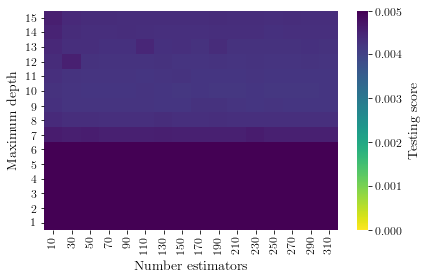

In [56]:
# Draw a heatmap with the numeric values in each cell
fig, ax = plt.subplots()
sns.heatmap(-pivot_test_score, annot=False, fmt='0.1%', ax=ax, vmin=0, vmax=0.005, cmap='viridis_r', 
            cbar_kws={'label': 'Testing score'}, robust=True, square=False)

# for _, spine in ax.spines.items():
#     spine.set_visible(True)
    
ax.set_xlabel('Number estimators')
ax.set_ylabel('Maximum depth')
ax.invert_yaxis()

plt.xticks(rotation=90) 
plt.yticks(rotation=0) 

outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation',
                       'grid-search-max_depth-n_estimators-heatmap.png')
# plt.savefig(outfile)
plt.show()

In [ ]:
max_depth_values = np.arange(1, 16, dtype=int)
df_cv_max_depth = comp.cross_validate_comp(
                            df_sim_train, df_sim_test, pipeline_str, 
                            param_name='max_depth', param_values=max_depth_values,
                            feature_list=feature_list, target='energy_s125_diff', 
                            scoring=mean_squared_error, num_groups=num_groups, n_splits=10,
                            verbose=True, n_jobs=1)
#                             verbose=True, n_jobs=min(len(max_depth_values), 15))

Performing 10-fold CV on 15 hyperparameter values (150 fits):
[##########                              ] | 25% Completed | 30min 13.9s

In [74]:
df_cv_max_depth

,classifier,n_splits,param_name,test_mean_Fe56Nucleus,test_mean_He4Nucleus,test_mean_O16Nucleus,test_mean_PPlus,test_mean_total,test_std_Fe56Nucleus,test_std_He4Nucleus,...,train_mean_Fe56Nucleus,train_mean_He4Nucleus,train_mean_O16Nucleus,train_mean_PPlus,train_mean_total,train_std_Fe56Nucleus,train_std_He4Nucleus,train_std_O16Nucleus,train_std_PPlus,train_std_total
param_value,,,,,,,,,,,,,,,,,,,,,
1,RF_energy_IC79.2010,10,max_depth,0.191055,0.201578,0.200909,0.203506,0.199426,0.005706,0.002168,...,0.190997,0.201558,0.200860,0.203505,0.199406,0.000795,0.000483,0.000461,0.000513,0.000369
2,RF_energy_IC79.2010,10,max_depth,0.057955,0.058069,0.058464,0.060171,0.058681,0.000849,0.000573,...,0.057909,0.058048,0.058416,0.060134,0.058646,0.000240,0.000225,0.000228,0.000218,0.000214
3,RF_energy_IC79.2010,10,max_depth,0.017886,0.017833,0.017089,0.019662,0.018135,0.000223,0.000281,...,0.017833,0.017774,0.017047,0.019614,0.018085,0.000103,0.000084,0.000060,0.000084,0.000071
4,RF_energy_IC79.2010,10,max_depth,0.008551,0.007897,0.007409,0.009862,0.008439,0.000170,0.000130,...,0.008501,0.007847,0.007366,0.009800,0.008388,0.000044,0.000046,0.000037,0.000046,0.000040
5,RF_energy_IC79.2010,10,max_depth,0.005287,0.005393,0.004875,0.007272,0.005727,0.000122,0.000117,...,0.005238,0.005339,0.004826,0.007206,0.005672,0.000029,0.000036,0.000028,0.000043,0.000031
6,RF_energy_IC79.2010,10,max_depth,0.004189,0.004410,0.003933,0.006265,0.004720,0.000115,0.000097,...,0.004134,0.004352,0.003877,0.006189,0.004659,0.000016,0.000022,0.000016,0.000033,0.000019
7,RF_energy_IC79.2010,10,max_depth,0.003441,0.004011,0.003411,0.005929,0.004225,0.000091,0.000093,...,0.003369,0.003935,0.003338,0.005820,0.004143,0.000014,0.000020,0.000013,0.000032,0.000017
8,RF_energy_IC79.2010,10,max_depth,0.003114,0.003776,0.003137,0.005727,0.003968,0.000074,0.000093,...,0.003014,0.003672,0.003038,0.005540,0.003844,0.000012,0.000013,0.000008,0.000028,0.000013
9,RF_energy_IC79.2010,10,max_depth,0.002914,0.003647,0.002987,0.005600,0.003817,0.000072,0.000098,...,0.002768,0.003490,0.002845,0.005277,0.003624,0.000008,0.000011,0.000006,0.000026,0.000010


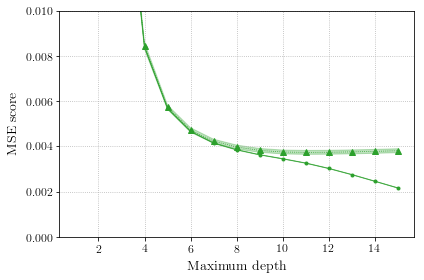

In [79]:
fig, ax = plt.subplots()

# Plot testing curve
ax.plot(df_cv_max_depth.index, df_cv_max_depth['test_mean_total'],
        marker='^', ls=':', color=color_dict['total'], label=composition+' testing set')
test_err_high = df_cv_max_depth['test_mean_total'] + df_cv_max_depth['test_std_total']
test_err_low = df_cv_max_depth['test_mean_total'] - df_cv_max_depth['test_std_total']
ax.fill_between(df_cv_max_depth.index, test_err_high, test_err_low,
                color=color_dict['total'], alpha=0.3)

# Plot training curve
ax.plot(df_cv_max_depth.index, df_cv_max_depth['train_mean_total'],
        marker='.', ls='-', color=color_dict['total'], label=composition+' training set')
train_err_high = df_cv_max_depth['train_mean_total'] + df_cv_max_depth['train_std_total']
train_err_low = df_cv_max_depth['train_mean_total'] - df_cv_max_depth['train_std_total']
ax.fill_between(df_cv_max_depth.index, train_err_high, train_err_low,
                color=color_dict['total'], alpha=0.3)
    
ax.set_xlabel('Maximum depth')
# ax.set_ylabel('R$^2$ CV score')
ax.set_ylabel('MSE score')
# ax.set_ylim(0.95, 1.0)
ax.set_ylim(0, 0.01)
ax.grid()
# ax.legend(title='True compositions')
# leg = ax.legend(loc='upper center', frameon=False,
#                  bbox_to_anchor=(0.5,  # horizontal
#                                  1.35),# vertical 
#                  ncol=len(comp_list) // 2, fancybox=False)
max_depth_outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation', 'validation-curves',
                                 '{}_max_depth.png'.format(pipeline_str))
comp.check_output_dir(max_depth_outfile)
# plt.savefig(max_depth_outfile)
plt.show()

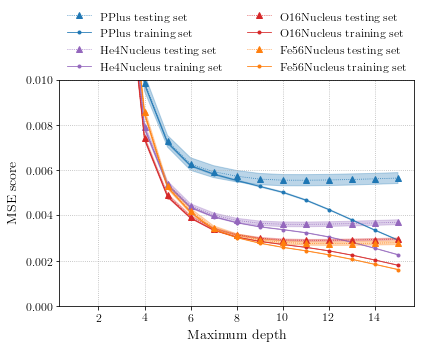

In [80]:
fig, ax = plt.subplots()
# for composition in comp_list + ['total']:
for composition in comp_list:
    # Plot testing curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['test_mean_{}'.format(composition)],
            marker='^', ls=':', color=color_dict[composition], label=composition+' testing set')
    test_err_high = df_cv_max_depth['test_mean_{}'.format(composition)] + df_cv_max_depth['test_std_{}'.format(composition)]
    test_err_low = df_cv_max_depth['test_mean_{}'.format(composition)] - df_cv_max_depth['test_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, test_err_high, test_err_low,
                    color=color_dict[composition], alpha=0.3)
    
    # Plot training curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['train_mean_{}'.format(composition)],
            marker='.', ls='-', color=color_dict[composition], label=composition+' training set')
    train_err_high = df_cv_max_depth['train_mean_{}'.format(composition)] + df_cv_max_depth['train_std_{}'.format(composition)]
    train_err_low = df_cv_max_depth['train_mean_{}'.format(composition)] - df_cv_max_depth['train_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, train_err_high, train_err_low,
                    color=color_dict[composition], alpha=0.3)
    
ax.set_xlabel('Maximum depth')
# ax.set_ylabel('R$^2$ CV score')
ax.set_ylabel('MSE score')
# ax.set_ylim(0.95, 1.0)
ax.set_ylim(0, 0.01)
ax.grid()
# ax.legend(title='True compositions')
leg = ax.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.35),# vertical 
                 ncol=len(comp_list) // 2, fancybox=False)
max_depth_outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation', 'validation-curves',
                                 '{}_max_depth.png'.format(pipeline_str))
comp.check_output_dir(max_depth_outfile)
# plt.savefig(max_depth_outfile)
plt.show()

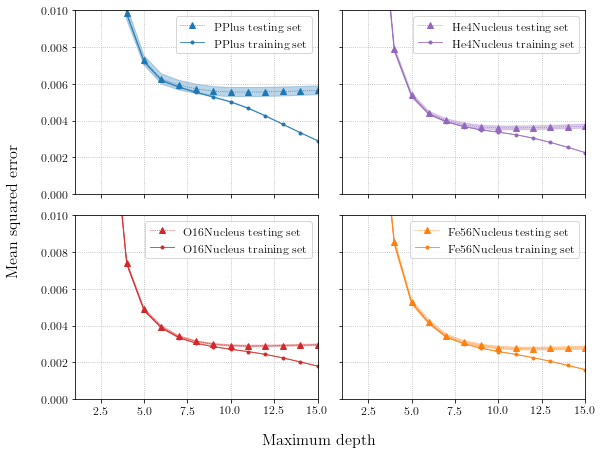

In [93]:
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
# for composition in comp_list + ['total']:
for composition, ax in zip(comp_list, axarr.flatten()):
    # Plot testing curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['test_mean_{}'.format(composition)],
            marker='^', ls=':', color=color_dict[composition], label=composition+' testing set')
    test_err_high = df_cv_max_depth['test_mean_{}'.format(composition)] + df_cv_max_depth['test_std_{}'.format(composition)]
    test_err_low = df_cv_max_depth['test_mean_{}'.format(composition)] - df_cv_max_depth['test_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, test_err_high, test_err_low,
                    color=color_dict[composition], alpha=0.3)
    
    # Plot training curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['train_mean_{}'.format(composition)],
            marker='.', ls='-', color=color_dict[composition], label=composition+' training set')
    train_err_high = df_cv_max_depth['train_mean_{}'.format(composition)] + df_cv_max_depth['train_std_{}'.format(composition)]
    train_err_low = df_cv_max_depth['train_mean_{}'.format(composition)] - df_cv_max_depth['train_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, train_err_high, train_err_low,
                    color=color_dict[composition], alpha=0.3)

    ax.set_xlim(max_depth_values.min(), max_depth_values.max())
    ax.set_ylim(0, 0.01)
    ax.grid()
    ax.legend(loc='upper right')
    
fig.text(0.5, -0.04, 'Maximum depth', ha='center', fontsize=16)
fig.text(-0.04, 0.5, 'Mean squared error', va='center', rotation='vertical', fontsize=16)

max_depth_outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation', 'validation-curves',
                                 '{}_max_depth_composition_grid.png'.format(pipeline_str))
comp.check_output_dir(max_depth_outfile)
plt.savefig(max_depth_outfile)
plt.show()

In [21]:
param_values = np.arange(10, 320, 20, dtype=int)
df_cv_n_estimators = cross_validate_comp(
# df_cv_max_depth = comp.analysis.modelevaluation.cross_validate_comp(
                            df_sim_train, df_sim_test, pipeline_str, 
                            param_name='n_estimators', param_values=param_values,
                            feature_list=feature_list, target='MC_log_energy', 
                            scoring='mse', num_groups=num_groups, n_splits=10,
                            verbose=True, n_jobs=10)
#                             verbose=True, n_jobs=min(len(param_values), 20))

Performing 10-fold CV on 16 hyperparameter values (160 fits):
[########################################] | 100% Completed |  4min 50.9s


In [22]:
df_cv_n_estimators

,classifier,n_splits,param_name,test_mean_heavy,test_mean_light,test_mean_total,test_std_heavy,test_std_light,test_std_total,train_mean_heavy,train_mean_light,train_mean_total,train_std_heavy,train_std_light,train_std_total
param_value,,,,,,,,,,,,,,,
10,RF_energy_IC86.2012,10,n_estimators,0.003910,0.005214,0.004589,0.000102,0.000278,0.000151,0.003721,0.004990,0.004382,0.000030,0.000023,0.000013
30,RF_energy_IC86.2012,10,n_estimators,0.003883,0.005177,0.004557,0.000110,0.000278,0.000156,0.003682,0.004953,0.004344,0.000024,0.000022,0.000015
50,RF_energy_IC86.2012,10,n_estimators,0.003873,0.005175,0.004551,0.000103,0.000276,0.000150,0.003675,0.004946,0.004337,0.000019,0.000023,0.000013
70,RF_energy_IC86.2012,10,n_estimators,0.003872,0.005172,0.004549,0.000106,0.000277,0.000152,0.003673,0.004945,0.004336,0.000015,0.000024,0.000011
90,RF_energy_IC86.2012,10,n_estimators,0.003868,0.005171,0.004547,0.000106,0.000277,0.000152,0.003671,0.004942,0.004333,0.000015,0.000023,0.000011
110,RF_energy_IC86.2012,10,n_estimators,0.003868,0.005171,0.004547,0.000107,0.000275,0.000151,0.003670,0.004942,0.004333,0.000015,0.000023,0.000012
130,RF_energy_IC86.2012,10,n_estimators,0.003868,0.005172,0.004547,0.000106,0.000277,0.000154,0.003670,0.004941,0.004332,0.000015,0.000023,0.000012
150,RF_energy_IC86.2012,10,n_estimators,0.003869,0.005172,0.004548,0.000106,0.000277,0.000153,0.003670,0.004942,0.004333,0.000014,0.000022,0.000011
170,RF_energy_IC86.2012,10,n_estimators,0.003869,0.005172,0.004547,0.000106,0.000276,0.000153,0.003670,0.004941,0.004333,0.000014,0.000023,0.000011


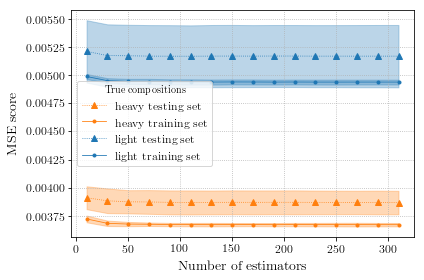

In [23]:
fig, ax = plt.subplots()
for composition in comp_list:
    # Plot testing curve
    ax.plot(df_cv_n_estimators.index, df_cv_n_estimators['test_mean_{}'.format(composition)],
            marker='^', ls=':', color=color_dict[composition], label=composition+' testing set')
    test_err_high = df_cv_n_estimators['test_mean_{}'.format(composition)] + df_cv_n_estimators['test_std_{}'.format(composition)]
    test_err_low = df_cv_n_estimators['test_mean_{}'.format(composition)] - df_cv_n_estimators['test_std_{}'.format(composition)]
    ax.fill_between(df_cv_n_estimators.index, test_err_high, test_err_low,
                    color=color_dict[composition], alpha=0.3)
    
    # Plot training curve
    ax.plot(df_cv_n_estimators.index, df_cv_n_estimators['train_mean_{}'.format(composition)],
            marker='.', ls='-', color=color_dict[composition], label=composition+' training set')
    train_err_high = df_cv_n_estimators['train_mean_{}'.format(composition)] + df_cv_n_estimators['train_std_{}'.format(composition)]
    train_err_low = df_cv_n_estimators['train_mean_{}'.format(composition)] - df_cv_n_estimators['train_std_{}'.format(composition)]
    ax.fill_between(df_cv_n_estimators.index, train_err_high, train_err_low,
                    color=color_dict[composition], alpha=0.3)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('MSE score')
# ax.set_ylabel('MSE testing score')
# ax.set_ylim(0, 0.01)
ax.grid()
ax.legend(title='True compositions')
plt.show()

## Energy reconstruction performance plots

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


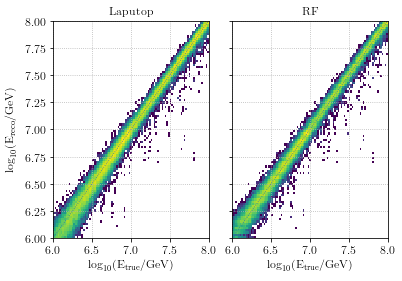

In [9]:
h_lap, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['lap_log_energy'],
                                        bins=np.linspace(6.0, 8.0, 100))
h_lap = np.rot90(h_lap)
h_lap = np.flipud(h_lap)

h_reco, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], reco_log_energy,
                                         bins=np.linspace(6.0, 8.0, 100))
h_reco = np.rot90(h_reco)
h_reco = np.flipud(h_reco)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

gs = gridspec.GridSpec(1, 2, wspace=0.15)
ax_lap = plt.subplot(gs[0])
# ax_reco = plt.subplot(gs[1])
ax_reco = plt.subplot(gs[1], sharey=ax_lap)

# fig, ax = plt.subplots()
for h, ax, title in zip([h_lap, h_reco], [ax_lap, ax_reco], ['Laputop', 'RF']):
    ax.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none',
              aspect='auto')
    ax.plot([6, 8], [6, 8], marker='None', ls=':')
    # ax.set_xlim([6.4, 8.0])
    # ax.set_ylim([6.4, 8.0])
    ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
#     ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
    ax.set_title(title)
    ax.grid()
    
ax_reco.tick_params(labelleft='off')
ax_lap.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')

# plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_reco_energy_{}.png'.format(config))
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

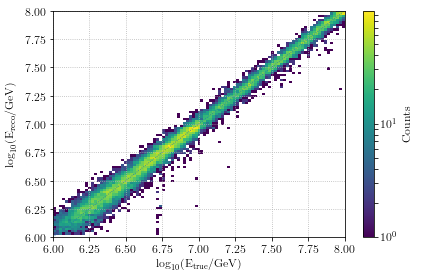

In [26]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], reco_log_energy,
                                    bins=np.linspace(6.0, 8.0, 100))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
ax.plot([6, 8], [6, 8], marker='None', ls=':')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_reco_energy.png')
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

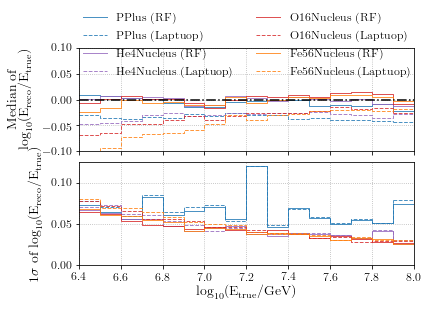

In [55]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']
log_energy_bins = np.arange(6.4, 8.1, 0.1)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

for composition in comp_list:
#     comp_mask = df_sim_test['MC_comp_class'] == composition
    
    # Plot RF reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    plotting.plot_steps(log_energy_bins, stds, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
    # Plot Laputop reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                lap_energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (Laptuop)', ax=ax1)

    plotting.plot_steps(log_energy_bins, stds, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8, 
                        label=composition+' (Laptuop)', ax=ax2)

ax1.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')
ax1.grid()
# ax1.legend(title='True composition')
leg = ax1.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.45),# vertical 
                 ncol=len(comp_list) // 2, fancybox=False)

ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax2.grid()

ax2.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_{}.png'.format(config))
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

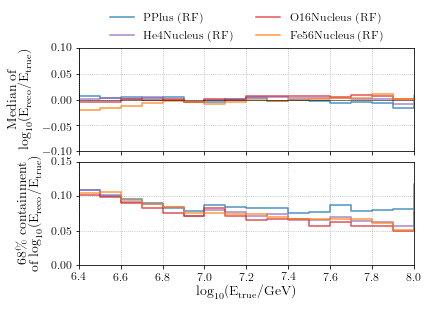

In [92]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']
# log_energy_bins = np.arange(5.5, 9.1, 0.1)

log_energy_bins = np.concatenate((np.arange(5.5, energybins.log_energy_min, 0.1),
                                  energybins.log_energy_bins))

# log_energy_bins = np.arange(6.4, 8.1, 0.1)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

for composition in comp_list:
    
    # Plot RF reco energy 
    _, medians, error = comp.analysis.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1.5,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    plotting.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1.5,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
#     # Plot Laputop reco energy 
#     _, medians, error = comp.analysis.get_medians(
#                                 df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
#                                 lap_energy_res[comp_mask_test[composition]],
#                                 log_energy_bins)

#     plotting.plot_steps(log_energy_bins, medians, lw=1.5, ls='--',
#                         color=color_dict[composition], alpha=0.8,
#                         label=composition+' (Laputop)', ax=ax1)

#     plotting.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1.5, ls='--',
#                         color=color_dict[composition], alpha=0.8, 
#                         label=composition+' (Laputop)', ax=ax2)

ax1.axhline(0, marker='None', linestyle='-', color='k', lw=0.5)
ax1.axvline(6.4, marker='None', linestyle=':', color='k', lw=0.75)
ax2.axvline(6.4, marker='None', linestyle=':', color='k', lw=0.75)

ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')
ax1.grid()
# ax1.legend(title='True composition')
leg = ax1.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
#                                  1.275),# vertical 
                                 1.45),# vertical 
#                                  1.85),# vertical 
                 ncol=len(comp_list)//2, fancybox=False)

ax2.set_ylabel('68\% containment\nof $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0, 0.15)
# ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax2.grid()

ax2.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_compare_{}.png'.format(config))
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


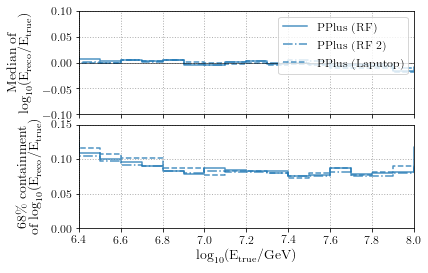

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


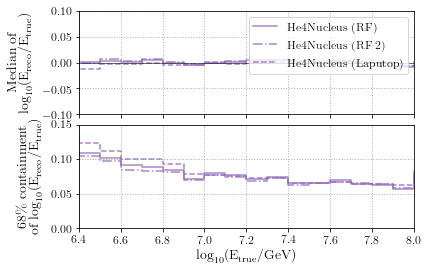

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


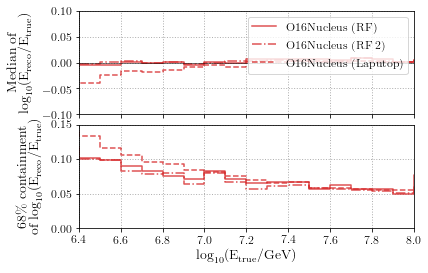

/data/user/jbourbeau/miniconda/envs/composition/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


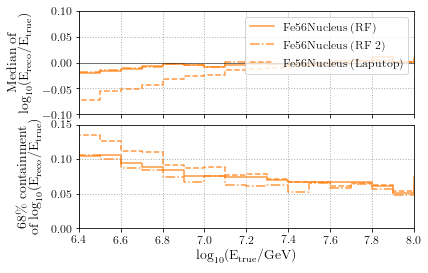

In [19]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
energy_res_2 = reco_log_energy_2 - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']
# log_energy_bins = np.arange(5.5, 9.1, 0.1)

log_energy_bins = np.concatenate((np.arange(5.5, energybins.log_energy_min, 0.1),
                                  energybins.log_energy_bins))

# log_energy_bins = np.arange(6.4, 8.1, 0.1)
for composition in comp_list:


    gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharex=ax1)

    # Plot RF reco energy 
    _, medians, error = comp.data_functions.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    comp.plot_steps(log_energy_bins, medians, lw=1.5,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    comp.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1.5,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
    # Plot RF reco energy 2
    _, medians, error = comp.data_functions.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res_2[comp_mask_test[composition]],
                                log_energy_bins)

    comp.plot_steps(log_energy_bins, medians, lw=1.5, ls='-.', 
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF 2)', ax=ax1)

    comp.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1.5, ls='-.',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF 2)', ax=ax2)

    
    
    # Plot Laputop reco energy 
    _, medians, error = comp.data_functions.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                lap_energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    comp.plot_steps(log_energy_bins, medians, lw=1.5, ls='--',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (Laputop)', ax=ax1)

    comp.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1.5, ls='--',
                        color=color_dict[composition], alpha=0.8, 
                        label=composition+' (Laputop)', ax=ax2)

    ax1.axhline(0, marker='None', linestyle='-', color='k', lw=0.5)
    ax1.axvline(6.4, marker='None', linestyle=':', color='k', lw=0.75)
    ax2.axvline(6.4, marker='None', linestyle=':', color='k', lw=0.75)

    ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
    ax1.set_ylim(-0.1, 0.1)
    ax1.tick_params(labelbottom='off')
    ax1.grid()
    ax1.legend(loc='upper right')
    # leg = ax1.legend(loc='upper center', frameon=False,
    #                  bbox_to_anchor=(0.5,  # horizontal
    # #                                  1.275),# vertical 
    #                                  1.85),# vertical 
    #                  ncol=len(comp_list)//2, fancybox=False)

    ax2.set_ylabel('68\% containment\nof $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
    ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
    ax2.set_ylim(0, 0.15)
    # ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
    ax2.grid()

    ax2.set_xlim(6.4, 8.0)

    energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                      'energy_res_compare_{}_{}.png'.format(config, composition))
    comp.check_output_dir(energy_res_outfile)
    plt.savefig(energy_res_outfile)

    plt.show()

In [12]:
reco_log_energy.min(), reco_log_energy.max()

(5.5794904682434039, 9.4649293863545978)

In [13]:
df_sim_test.MC_log_energy.min(), df_sim_test.MC_log_energy.max()

(5.2480956628028359, 9.4992049791454747)

In [15]:
df_sim_test.lap_log_energy.min(), df_sim_test.lap_log_energy.max()

(5.1358539936035763, 9.6503336874662615)

In [14]:
log_energy_bins

array([ 6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,
        7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,
        8.6,  8.7,  8.8,  8.9,  9. ])

KeyError: 'intermediate'

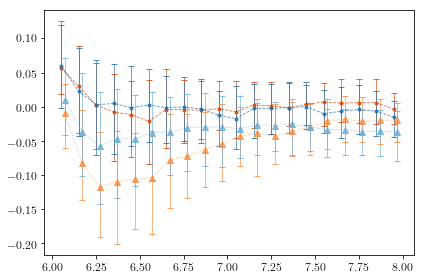

In [29]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']


fig, ax = plt.subplots()
res_color_dict = {'light': sns.color_palette('Blues', 3).as_hex()[::-1],
                  'heavy': sns.color_palette('Oranges', 3).as_hex()[::-1]}
for composition in comp_list:
    comp_mask = df_sim_test['MC_comp_class'] == composition
    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', ls='--', 
                color=res_color_dict[composition][0], alpha=0.8, label=composition + ' (RF)')

    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            lap_energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers + 0.02, bin_medians, yerr=error, marker='^', ls=':', 
                color=res_color_dict[composition][1], alpha=0.8, label=composition + ' (Laputop)')
    
ax.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
# ax.set_ylim(-0.1, 0.1)
ax.grid()
# ax.legend()
leg = ax.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.25),# vertical 
                 ncol=len(comp_list), fancybox=False)

# ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
# ax2.set_ylim(0)
# ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
# ax2.grid()

# ax.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_comparison.png')
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

In [ ]:
def plot_validation_curve(validation_dict, param_name, ylime=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    ax.plot(validation_dict['range'], validation_dict['train_mean'], label="Training score",
             color='C0')
    ax.fill_between(validation_dict['range'], validation_dict['train_mean'] - validation_dict['train_std'],
                     validation_dict['train_mean'] + validation_dict['train_std'], alpha=0.2,
                     color='C0')
    
    ax.plot(validation_dict['range'], validation_dict['test_mean'], label="Cross-validation score",
                 color='C2')
    ax.fill_between(validation_dict['range'], validation_dict['test_mean'] - validation_dict['test_std'],
                     validation_dict['test_mean'] + validation_dict['test_std'], alpha=0.2,
                     color='C2')
    
    ax.set_xlabel(param_name)
    ax.set_ylabel('Median energy resolution')
    ax.grid()
    ax.legend()
    
    return ax

## Validation curve for maximum tree depth

In [ ]:
max_depth_validation = {}
max_depth_validation['range'] = np.arange(1, 11)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='max_depth', param_range=max_depth_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
max_depth_validation['train_mean'] = np.mean(train_scores, axis=1)
max_depth_validation['train_std'] = np.std(train_scores, axis=1)
max_depth_validation['test_mean'] = np.mean(test_scores, axis=1)
max_depth_validation['test_std'] = np.std(test_scores, axis=1)

In [ ]:
fig, ax = plt.subplots()
ax = plot_validation_curve(max_depth_validation, 'Maximum tree depth', ax=ax)
plt.show()

In [ ]:
max_depth_validation

In [ ]:
clf.set_params(max_depth=20)

In [ ]:
n_estimators_validation = {}
n_estimators_validation['range'] = np.arange(10, 500, 100)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='n_estimators', param_range=n_estimators_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
n_estimators_validation['train_mean'] = np.mean(train_scores, axis=1)
n_estimators_validation['train_std'] = np.std(train_scores, axis=1)
n_estimators_validation['test_mean'] = np.mean(test_scores, axis=1)
n_estimators_validation['test_std'] = np.std(test_scores, axis=1)

In [ ]:
n_estimators_validation

In [ ]:
fig, ax = plt.subplots()
ax = plot_validation_curve(n_estimators_validation, 'Number of iterations', ax=ax)
plt.show()

In [ ]:
clf.set_params(n_estimators=200)

In [ ]:
clf = clf.fit(sim_train.X, sim_train.y)
train_pred = clf.predict(sim_train.X)
# train_acc = mean_squared_error(sim_train.y, train_pred)
train_score = median_energy_res(sim_train.y, train_pred)

test_pred = clf.predict(sim_test.X)
# test_acc = mean_squared_error(sim_test.y, test_pred)
test_score = median_energy_res(sim_test.y, test_pred)
print('Testing score: {}'.format(test_score))
print('Training score: {}'.format(train_score))

In [ ]:
energy_bins = 10**np.arange(5.0, 9.51, 0.1)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

In [ ]:
light_mask = sim_test.comp == 'light'
heavy_mask = sim_test.comp == 'heavy'

In [ ]:
energy_resolution = np.log10(test_pred/sim_test.y)
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[light_mask],
                                                                           energy_resolution[light_mask],
                                                                           np.log10(energy_bins))
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[heavy_mask],
                                                                           energy_resolution[heavy_mask],
                                                                           np.log10(energy_bins))

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(np.log10(energy_midpoints), bin_medians_light, yerr=error_light,
            marker='.', ls='None', label='light')
ax.errorbar(np.log10(energy_midpoints), bin_medians_heavy, yerr=error_heavy,
            marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', linestyle='-.', color='k')
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlim([6.3, 9.0])
ax.set_ylim([-0.15, 0.15])
ax.legend()
plt.grid()
# plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()